In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

<br>

# Page Rank / Eigenvector Centrality
---

Let us represent the graph of web page links as a directed graph. Each link of each page gets a **weight** that is inversely proportional to the number of links that go out of the page. These weights represent the probability of going out of the page by that link (a **stochastic matrix**). We then modify this graph so that:

* each page has its own link to itself (action of staying on that page)
* each sink page has in fact links to everyone (search restarts randomly)

The goal is to look for the web page that contains the source information, from which the other web pages are feeding. We want the source, the unaltered information, not the numerous indirections.

Links:

* https://snap.stanford.edu/class/cs224w-readings/Brin98Anatomy.pdf
* https://en.wikipedia.org/wiki/Eigenvector_centrality

<br>

### The idea

To do so, the idea behind page rank is to look for the **eigen vectors of the adjacency matrix** that represents the directed graph of links and web pages described above, with weights to make sure that all outgoing edges sum to 1. This process is equivalent as looking for **stationary distributions** in **markov chains**. Why would it work?

First note that if we looked at the eigen vectors of the transition matrix with no outgoing edges added to the sink pages, we would be looking for pages that maps to themselves after the transition (eigenvectors once again). But the problem is that this might return nodes that have no incoming links either. These pages are not interesting.

The whole goal of Pank Rank is to instead simulate a person that would browse the web, and naturally go toward the sources of information, then start another search for more information once it reached that information. If many pages link again to this sink page, it is all the more reliable.

<br>

### Relative centrality

We can show that the algorithm above is equivalent to looking for the scores $x_i$ of the nodes of the graph (where $i$ is the index of the node), based on the sum of the score of the neighbors that lead to this node, weighted by the probability to come to that node (encoded in the transition matrix $A$):

&emsp; $\displaystyle \forall i, x_i = \frac{1}{\lambda} \sum_j A_{ij} x_j$
&emsp; where
&emsp; $\lambda$ is a constant that allows the process to stabilize

Nodes that are referenced by "important" nodes (even by a few of them) will be favored. Nodes that are referenced by a lot of nodes as well, and will transfer this importance to the nodes they refer to. This can be rearranged to show that this is equivalent to looking for the eigenvectors of $A$:

&emsp; $A x = \lambda x$
&emsp; $\iff$
&emsp; $\forall i, \lambda x_i = \sum_j A_{ij} x_j$

But there can be many such eigenvalues. And so there can be many different scores (the values $x_i$ for each eigen vector $x$). Which score should we select? The additional requirement is that we all the entries of the eigenvector must correspond to a distribution of probability on the pages (as for **markov chain**): it is enough for each of them to be greater than zero (because we can always divide by the sum of the component of the vector - normalize the vector in terms of probabilities).

It can be proven that there is one such vector, and that this is equivalent to selecting the eigenvector with the highest eigenvalue.

**todo: proof here**

<br>

### Stochastic approach (TODO: verify)

The problem with looking for the eigen vectors of a transition matrix is the sheer size of the transition matrix, and the cost of computing these eigen values. This grows in $O(N^2)$ where $N$ is the number of pages.

We can instead follow a stochastic approach that consists in repeatedly start at a random page, and follow one of its link randomly (a bit like **rollouts in monte carlo tree search**) and stop when we reach a **sink** (a page with no out-going links). The most relevant pages are the ones we always end up falling to.

Sink nodes that have no incoming links will not be found very often, and so this takes care of source information that no one deemed interesting to refer to.

<br>

### Filtering by topics

Of course, there are very few pages that have no outgoing links. But we can filter the outgoing links by verifying these out-going links fall on the same search topic as the one we initially looked for. The graph we end up applying the method described above is therefore a sub-graph, filtered by keywords, and we are trying to rank the nodes of that graph.

<br>

# Example
---

We will take the following graph as example:

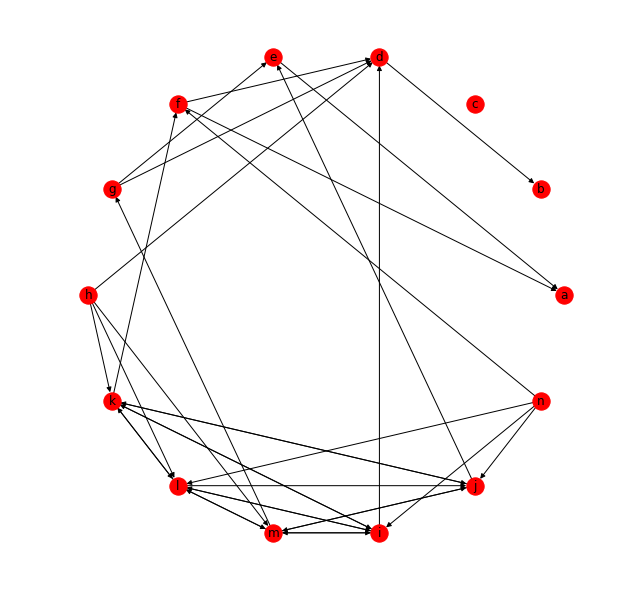

In [33]:
def draw_graph(g):
    gx = nx.DiGraph()
    for a, neigh in g.items():
        gx.add_node(a)
        for b in neigh:
            gx.add_edge(a, b)
    nx.draw_circular(gx, with_labels=True)
    
g = {}

# The node with the information
g['a'] = []
g['b'] = []
g['c'] = []

# Sites that relate toward the main nodes
g['d'] = list("b")
g['e'] = list("a")
g['f'] = list("ad")
g['g'] = list("de")

# Cluster of sites that all reference each other
g['h'] = list("dklm")
g['i'] = list("dklm")
g['j'] = list("ejkm")
g['k'] = list("fijl")
g['l'] = list("ijkm")
g['m'] = list("gijl")
g['n'] = list("fijl")

# Drawing the result
plt.figure(figsize=(8,8))
draw_graph(g)

<br>

### Looking at the data

Measures of the number of outgoing links and reference counts will show us that these are not pointing to our source information: the nodes 'a', 'b' and 'c'.

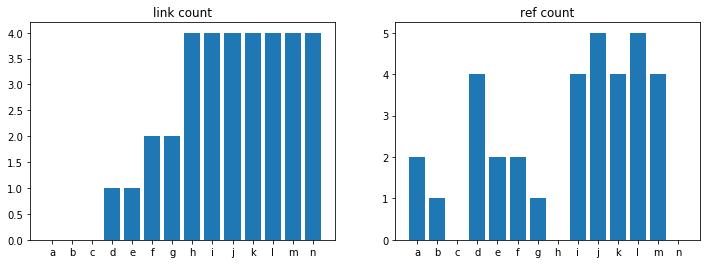

In [34]:
def reverse_graph(g):
    gr = {}
    for a, neigh in g.items():
        for b in neigh:
            gr.setdefault(b, []).append(a)
    return gr

def draw_link_count(g):
    gr = reverse_graph(g)
    site = []
    ref_count = []
    link_count = []
    for k, v in sorted(g.items()):
        site.append(k)
        link_count.append(len(v))
        ref_count.append(len(gr.get(k, [])))

    _, ax = plt.subplots(figsize=(12,4), ncols=2)
    ax[0].bar(site, link_count)
    ax[0].set_title('link count')
    ax[1].bar(site, ref_count)
    ax[1].set_title('ref count')
    plt.plot()
    
draw_link_count(g)

Let us now create a transition matrix for the outgoing edges. This matrix is such that $A_{ij} = 1$ if the page $j$ has a link toward $i$ (the outputs of matrices are the rows).

In [35]:
stay_prob = 0.15
nodes = list(sorted(g.keys()))
N = len(nodes)

adj_matrix = np.zeros(shape=(N, N))
for a, neigh in g.items():
    a = ord(a)-ord('a')
    degree = len(neigh)
    if degree > 0:
        # Continue to surf
        adj_matrix[a,a] = stay_prob
        for b in neigh:
            b = ord(b)-ord('a')
            adj_matrix[b,a] = (1-stay_prob) / degree
    else:
        # Restart surfing
        for b in nodes:
            b = ord(b)-ord('a')
            if b != a:
                adj_matrix[b,a] = (1-stay_prob) / (N - 1)
        adj_matrix[a,a] = stay_prob

print(np.round(adj_matrix, decimals=2))

[[0.15 0.07 0.07 0.   0.85 0.42 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.07 0.15 0.07 0.85 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.07 0.07 0.15 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.07 0.07 0.07 0.15 0.   0.42 0.42 0.21 0.21 0.   0.   0.   0.   0.  ]
 [0.07 0.07 0.07 0.   0.15 0.   0.42 0.   0.   0.21 0.   0.   0.   0.  ]
 [0.07 0.07 0.07 0.   0.   0.15 0.   0.   0.   0.   0.21 0.   0.   0.21]
 [0.07 0.07 0.07 0.   0.   0.   0.15 0.   0.   0.   0.   0.   0.21 0.  ]
 [0.07 0.07 0.07 0.   0.   0.   0.   0.15 0.   0.   0.   0.   0.   0.  ]
 [0.07 0.07 0.07 0.   0.   0.   0.   0.   0.15 0.   0.21 0.21 0.21 0.21]
 [0.07 0.07 0.07 0.   0.   0.   0.   0.   0.   0.21 0.21 0.21 0.21 0.21]
 [0.07 0.07 0.07 0.   0.   0.   0.   0.21 0.21 0.21 0.15 0.21 0.   0.  ]
 [0.07 0.07 0.07 0.   0.   0.   0.   0.21 0.21 0.   0.21 0.15 0.21 0.21]
 [0.07 0.07 0.07 0.   0.   0.   0.   0.21 0.21 0.21 0.   0.21 0.15 0.  ]
 [0.07 0.07 0.07 0.   0.   0.   0.   0.   0.   0.  

<br>

### Page Rank with eigenvectors

Instead, to get the scores, we can look at the eigen vectors of the transition matrix, and sum the contribution of each of the dimensions of the vectors. In other words, the page probabilities are added, weighted by the eigen value (which should be one **todo - check**): the more a page appears, the higher its score.

[ 0.98418071+0.00000000e+00j -0.05143606+2.88009371e-01j
 -0.05143606-2.88009371e-01j  0.42212488+0.00000000e+00j
 -0.26655466+0.00000000e+00j -0.08702235+0.00000000e+00j
  0.27617835+0.00000000e+00j  0.16723442+0.00000000e+00j
  0.08461538+0.00000000e+00j  0.08461538+0.00000000e+00j
  0.15      +4.49660565e-09j  0.15      -4.49660565e-09j
  0.15      +0.00000000e+00j  0.15      +0.00000000e+00j]
Order: ['j', 'b', 'l', 'a', 'm', 'k', 'i', 'd', 'e', 'f', 'g', 'n', 'h', 'c']
Score: [0.35, 0.34, 0.34, 0.34, 0.33, 0.33, 0.33, 0.31, 0.22, 0.16, 0.14, 0.06, 0.06, 0.05]


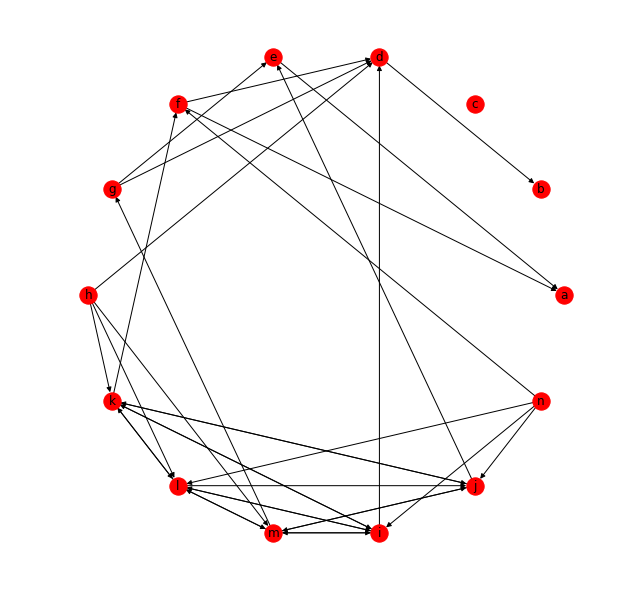

In [41]:
def highest_eigenvector(m):
    vals, vects = np.linalg.eig(m)
    print(vals)
    idx = np.argsort(vals)
    idx = idx[vals[idx] > 0]
    return vals[idx[-1]], vects.T[idx[-1]]

def rank_pages(m):
    scores = np.zeros(N)
    val, scores = highest_eigenvector(adj_matrix)
    scores = np.abs(scores)
    idx = np.argsort(scores)[::-1]
    return idx, scores[idx]

pages, scores = rank_pages(adj_matrix)
print("Order:", [chr(p+ord('a')) for p in pages])
print("Score:", list(np.round(scores, decimals=2)))

plt.figure(figsize=(8,8))
draw_graph(g)

<br>

### Page Rank: stochastic version

In [42]:
counts = {}
stay_prob = 0.15

neighbors = []
for _ in range(100_000):
    if np.random.rand() < stay_prob or not neighbors:
        n = chr(ord('a') + np.random.randint(0,N))
    else:
        n = np.random.choice(neighbors)
    counts[n] = counts.get(n, 0) + 1
    neighbors = g.get(n, [])

hist = [(n,c) for n, c in counts.items()]
hist.sort(key=lambda p: p[1], reverse=True)
print(hist)

[('j', 11152), ('a', 10150), ('b', 9905), ('l', 9362), ('k', 9274), ('m', 9202), ('i', 8990), ('d', 8804), ('e', 6616), ('f', 4958), ('g', 4333), ('h', 2463), ('c', 2415), ('n', 2376)]
